# Visualizing the prior graph from real data

In [1]:
import pandas as pd
import numpy as np
from tqdm import tqdm
import pickle
import warnings
from statsmodels.tsa.stattools import grangercausalitytests
import scanpy as sc
from joblib import Parallel, delayed
import os
import networkx as nx
import re

import matplotlib.pyplot as plt

In [2]:
trajectory_file = '../data/trajectory_1_natalia/traj_data.npy' 
gene_names_file='../data/trajectory_1_natalia/gene_names.txt'
granger_p_val_file = '../data/cell_cycle_RG/granger_RGtoIPCtoNeuron_p.csv'
granger_coef_file = '../data/cell_cycle_RG/granger_RGtoIPCtoNeuron_c.csv'

seed=42

In [3]:
from pathlib import Path

# Load trajectory data from file
trajectory_path = Path(trajectory_file)
with open(trajectory_path, "rb") as f:
    trajectories = np.load(f)

print(trajectories.shape)

gene_names_path = Path(gene_names_file)
with open(gene_names_path, "r") as f:
    gene_names = [line.strip() for line in f.readlines()]

(100, 3515)


In [4]:

sample_id = 27
data_path = f"../data/cell_cycle_RG"
traj_types = np.load(f'{data_path}/traj_types.npy')
traj_gene_sp_hvg = np.load(f'{data_path}/traj_gene_sp_hvg.npy')
hvg = np.loadtxt(f'{data_path}/hvg.txt', dtype=str)
traj_type_dict = {
    1: r'RG$\to$IPC$\to$Neuron',
    2: r'Cell Cycle',
    3: r'RG(G1)$\to$Neuron I'
}
trajs = [traj_gene_sp_hvg[:,traj_types == i,:] for i in np.unique(traj_types)]
trajs_meancell = [traj.mean(axis=1) for traj in trajs]
color_dict = {
    1: 'red',
    2: 'blue',
    3: 'green'
}
cmap_dict = {
    1: 'Reds',
    2: 'Blues',
    3: 'Greens'
}
gene_names = hvg

sample_id = 27
traj_types = ['RGtoIPCtoNeuron', 'RG_G1_toNeuronI']
traj_type = traj_types[0]
pval_df = pd.read_csv(f'{data_path}/granger_{traj_type}_p.csv', index_col=0)
coef_df = pd.read_csv(f'{data_path}/granger_{traj_type}_c.csv', index_col=0)

log_pval_df = -np.log(pval_df + 2 ** -10)
coef_sign_df = np.sign(coef_df)
signed_score_df = log_pval_df * coef_sign_df
signed_score_df.columns = signed_score_df.columns.str.strip('_y')
signed_score_df.index = signed_score_df.index.str.strip('_x')

In [5]:
signed_score_df

,ENSG00000241860,ACAP3,CCNL2,ATAD3B,CDK11B,CDK11A,PLCH2,PRDM16,AJAP1,NPHP4,...,PCDH11Y,TBL1Y,USP9Y,UTY,NLGN4Y,ENSG00000286201,MT-ND1,MT-ATP8,MT-ND4L,MT-ND5
CAMTA1,1.117573,-1.647401,-0.994032,0.040723,0.037259,0.004916,-2.586529,-0.007449,0.821386,0.218838,...,0.951531,5.463985,-1.671231,0.580273,0.737506,0.437503,-0.001163,0.149485,-0.264430,0.027772
SMYD3,0.209802,-0.090574,-1.765214,-6.454817,-0.901519,-2.162299,-6.872474,-6.365802,6.930521,-0.929643,...,4.892491,1.542272,-2.017681,-3.260494,1.600524,5.164229,0.263679,0.721548,0.001696,0.668459
FOXP2,3.728114,0.381281,-0.865178,0.049136,0.354755,0.418237,-5.966027,-3.267979,6.549412,0.496531,...,6.897899,2.636556,-2.046193,-0.135563,6.331939,2.697125,0.484388,0.906967,0.118061,0.728128
NCOA2,6.930293,-3.219403,-6.928570,0.119456,0.225472,0.194013,-4.233879,-1.415740,3.376653,1.644882,...,5.159610,5.782176,-6.815784,0.372601,3.403074,1.431866,0.355698,0.621733,0.081310,0.552500
ZNF598,1.032149,0.960399,-0.196305,2.112469,3.992904,3.364246,-6.035426,-6.324735,6.928999,0.130027,...,5.535672,1.567273,-0.235061,-0.633230,3.067054,6.920853,1.626420,2.490460,0.472254,1.727051
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
ZNF780B,1.957882,0.035389,-1.471008,-0.306438,0.288307,0.290796,-6.652076,-4.431162,6.931472,-0.112564,...,6.931472,2.507826,-2.340061,-1.536964,6.931469,6.678487,0.634884,1.111704,0.184777,0.947916
THRB,-0.029210,0.038802,-1.324895,-6.931472,-3.513316,-6.910190,-6.931132,-6.800636,6.712011,-0.954522,...,2.930684,1.284991,-1.476722,-2.564803,0.589644,3.202997,0.126482,0.604214,-0.072578,0.575995
ZNF808,1.433337,2.562118,0.779940,3.242324,5.262315,3.911130,-0.554377,-6.677513,6.275130,0.897596,...,4.301183,1.062707,1.007322,0.167544,3.007494,4.965032,5.812445,6.429481,1.706228,4.613674
ARHGAP35,1.741522,-0.565157,-3.216863,-1.014627,-0.337975,-0.562120,-6.886764,-3.994932,6.114872,-1.140761,...,6.920402,2.503505,-5.054810,-2.251921,6.045363,1.254637,0.121453,0.452324,-0.086742,0.412081


# Constructing the Prior Graph

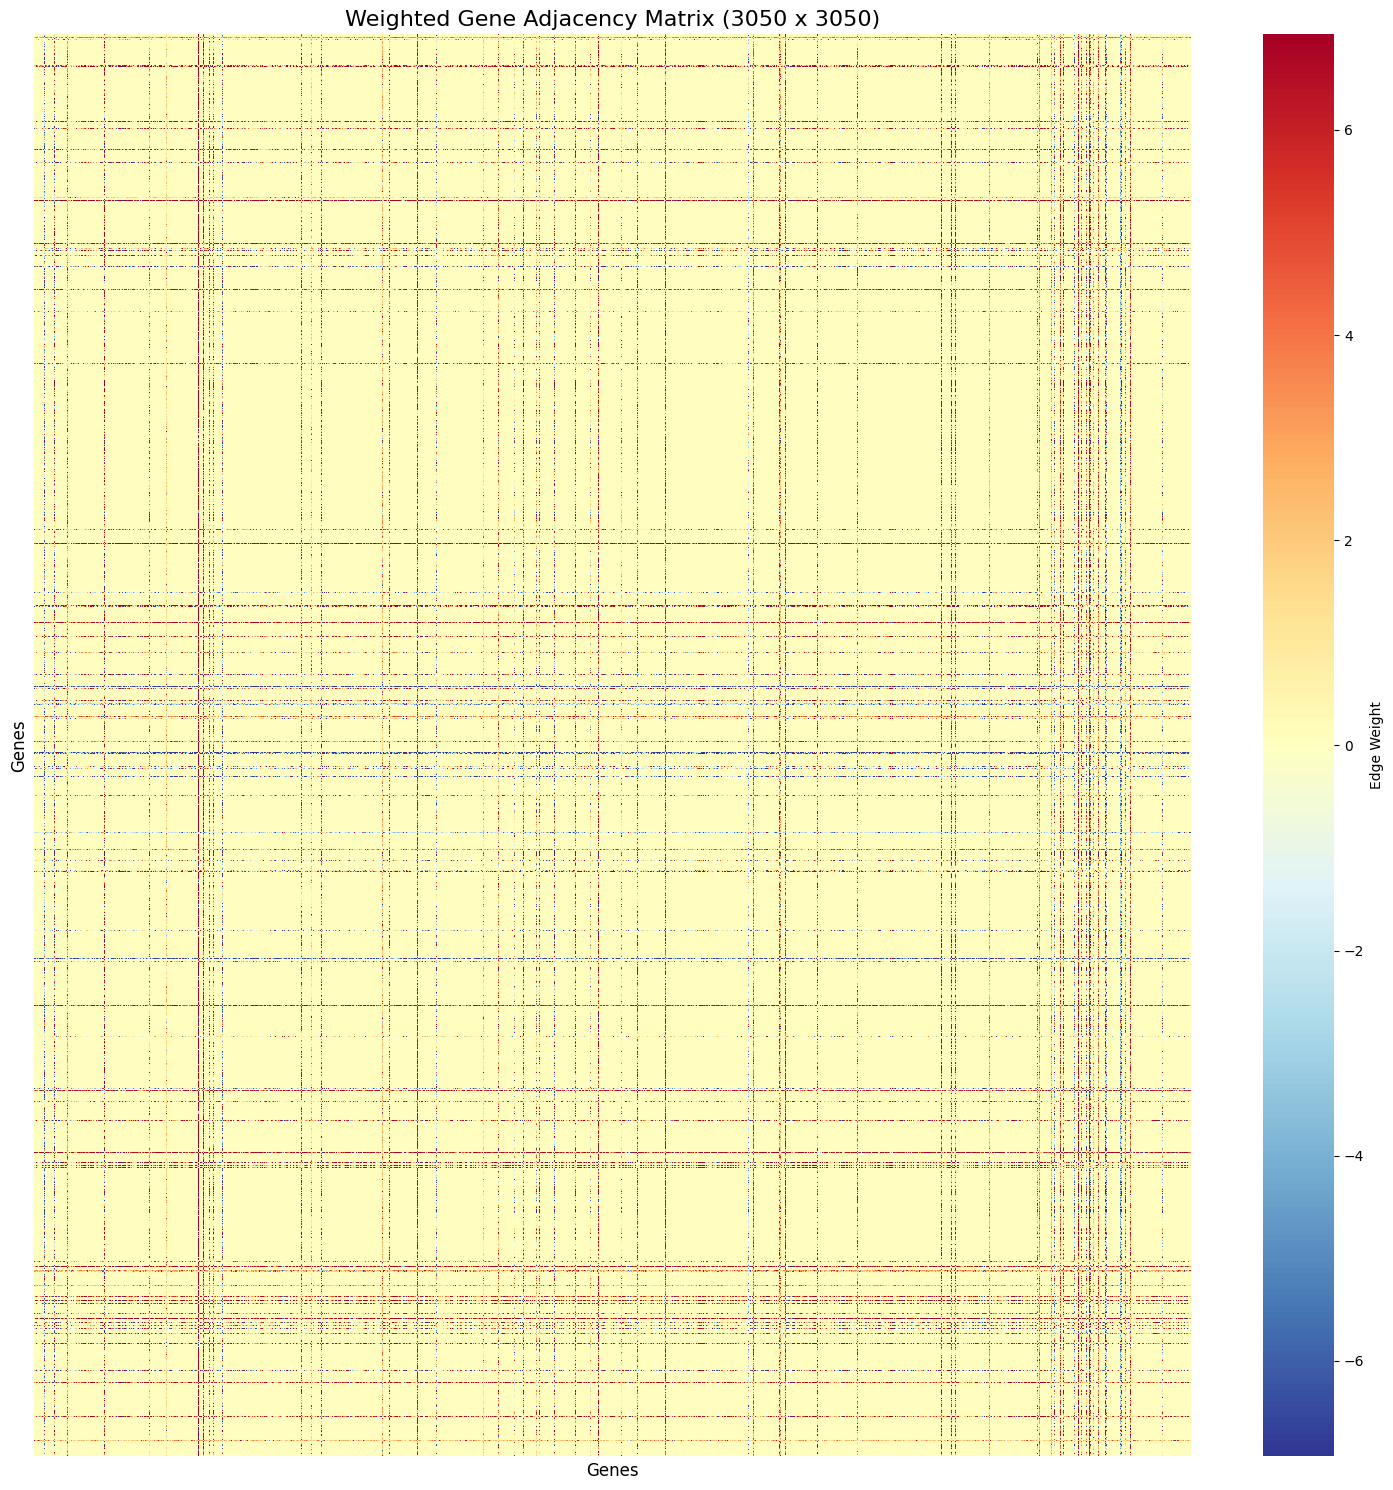

Min weight: -6.931471805599453
Max weight: 6.931471805599453
Mean weight (non-zero): 0.3672168671253814
Number of non-zero edges: 1232956


In [7]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd

# Assuming:
# adj_matrix: your 180 x 3050 matrix
# gene_names: list/array of all 3050 gene names
adj_matrix = signed_score_df


# If adj_matrix is a pandas DataFrame, get the 180 gene names from its index
gene_names_180 = adj_matrix.index.tolist()

# If adj_matrix is a numpy array, you need to have the 180 gene names separately:
# gene_names_180 = ['gene1', 'gene2', ...]  # Your 180 gene names

# Create a mapping from gene names to their positions in the full 3050 list
gene_to_idx = {gene: idx for idx, gene in enumerate(gene_names)}

# Get the indices of your 180 genes in the full gene list
indices_180 = [gene_to_idx[gene] for gene in gene_names_180]

# Convert adj_matrix to numpy array if it's a DataFrame
if isinstance(adj_matrix, pd.DataFrame):
    adj_array = adj_matrix.values
else:
    adj_array = adj_matrix

# Create the full 3050 x 3050 matrix initialized with zeros
n_genes = len(gene_names)
full_matrix = np.zeros((n_genes, n_genes))

# Place the weights at the correct positions
# For each of the 180 genes, place their connections across all 3050 genes
for i, gene_idx in enumerate(indices_180):
    full_matrix[gene_idx, :] = adj_array[i, :]

# Make it symmetric - for each connection from gene i to gene j, add connection from j to i
for i, gene_idx in enumerate(indices_180):
    full_matrix[:, gene_idx] = adj_array[i, :]

# Average the overlapping values in the 180x180 block
for i, gene_idx_i in enumerate(indices_180):
    for j, gene_idx_j in enumerate(indices_180):
        avg_weight = (adj_array[i, gene_idx_j] + adj_array[j, gene_idx_i]) / 2
        full_matrix[gene_idx_i, gene_idx_j] = avg_weight
        full_matrix[gene_idx_j, gene_idx_i] = avg_weight

# Create the heatmap
plt.figure(figsize=(15, 15))
sns.heatmap(full_matrix, cmap='RdYlBu_r', cbar=True, 
            xticklabels=False, yticklabels=False,
            cbar_kws={'label': 'Edge Weight'})
plt.title('Weighted Gene Adjacency Matrix (3050 x 3050)', fontsize=16)
plt.xlabel('Genes', fontsize=12)
plt.ylabel('Genes', fontsize=12)
plt.tight_layout()
plt.show()

# Check statistics
print(f"Min weight: {full_matrix.min()}")
print(f"Max weight: {full_matrix.max()}")
print(f"Mean weight (non-zero): {full_matrix[full_matrix != 0].mean()}")
print(f"Number of non-zero edges: {np.count_nonzero(full_matrix)}")

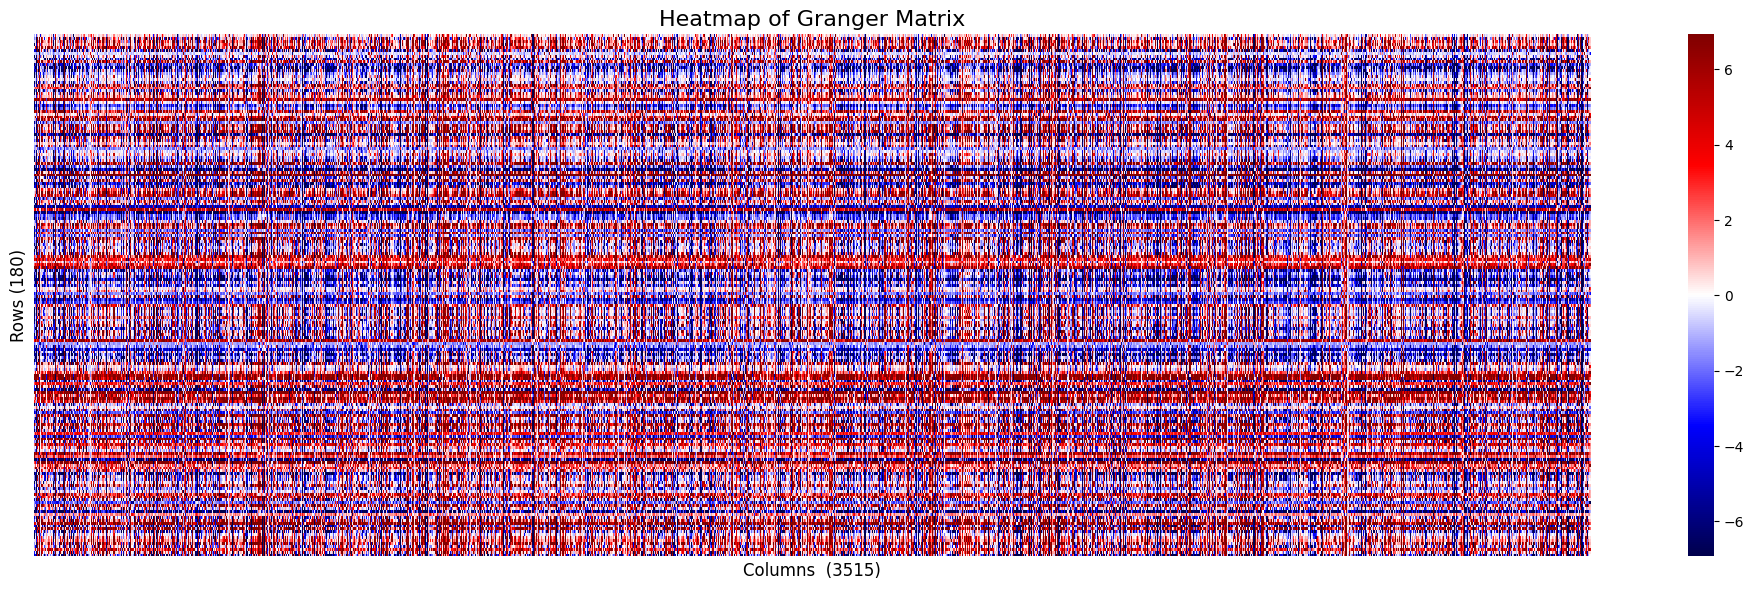

In [22]:
# Create the heatmap
plt.figure(figsize=(20, 6))
sns.heatmap(signed_score_df, cmap='seismic', cbar=True, xticklabels=False, yticklabels=False)
plt.title('Heatmap of Granger Matrix', fontsize=16)
plt.xlabel(f'Columns  ({signed_score_df.shape[1]})', fontsize=12)
plt.ylabel(f'Rows ({signed_score_df.shape[0]})', fontsize=12)
plt.tight_layout()
plt.show()

# Prior Graph Creation

In [16]:
# Add trajectory dimension if needed: (n_timepoints, n_genes) -> (n_timepoints, 1, n_genes)
if trajectories.ndim == 2:
    trajectories = trajectories[:, np.newaxis, :]

prior_graph = nx.DiGraph()

# Add all genes as nodes
for gene in gene_names:
    prior_graph.add_node(gene)

# Add edges based on signed_score_df
for source in signed_score_df.index:
    for target in signed_score_df.columns:
        score = signed_score_df.loc[source, target]
        if not np.isnan(score) and score != 0:
            prior_graph.add_edge(source, target, weight=score)

n_timepoints,n_trajectories, n_genes = trajectories.shape

In [17]:
trajectories.shape

(100, 1, 3515)

In [ ]:
# Set figure size
ref_g = prior_graph
ref_pos = nx.spring_layout(ref_g.to_undirected(), seed=seed)

# Color and label
for idx, node in enumerate(ref_g.nodes()):
    ref_g.nodes[node]['color'] = plt.get_cmap('viridis', len(gene_names))(idx)
    ref_g.nodes[node]['label'] = gene_names[idx]

# Extract node colors and labels
node_colors = [ref_g.nodes[n]['color'] for n in ref_g.nodes()]
node_labels = {n: ref_g.nodes[n]['label'] for n in ref_g.nodes()}

KeyboardInterrupt: 

In [ ]:
# Draw the graph

plt.figure(figsize=(12, 12))

nx.draw(
    ref_g,
    pos=ref_pos,
    with_labels=False,
    node_color=node_colors,
    edge_color='gray',
    arrows=True,
    node_size=100
)

# Draw node labels separately for clarity
nx.draw_networkx_labels(ref_g, pos=ref_pos, labels=node_labels, font_size=8)

plt.title("Prior Graph from Granger Causality", fontsize=14)
plt.axis('off')
plt.show()